<a href="https://colab.research.google.com/github/Madhusudhanbandi/S6/blob/master/EVA4_S6_ASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-11.0, 11.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [85]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True,  num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train,batch_size=128, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, batch_size=128,**dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(11),
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(19),
            
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 3

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
            # nn.Dropout(0.1)
        ) # output_size = 3


        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        

       
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        # x = self.convblock9(x)
        x = self.gap(x)
        # x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [87]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 11, 24, 24]             990
       BatchNorm2d-5           [-1, 11, 24, 24]              22
              ReLU-6           [-1, 11, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,980
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

**Without L1 and L2**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  # for batch_idx, (data, target) in enumerate(pbar):
    # get samples
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [152]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0






  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9832/10000 (98.32%)

EPOCH: 1








  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9874/10000 (98.74%)

EPOCH: 2










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9873/10000 (98.73%)

EPOCH: 3










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9877/10000 (98.77%)

EPOCH: 4










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9910/10000 (99.10%)

EPOCH: 5










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9880/10000 (98.80%)

EPOCH: 6










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9916/10000 (99.16%)

EPOCH: 7










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9929/10000 (99.29%)

EPOCH: 8










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9920/10000 (99.20%)

EPOCH: 9










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9914/10000 (99.14%)

EPOCH: 10










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9915/10000 (99.15%)

EPOCH: 11










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9938/10000 (99.38%)

EPOCH: 12










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9938/10000 (99.38%)

EPOCH: 13










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9944/10000 (99.44%)

EPOCH: 14










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 15










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9943/10000 (99.43%)

EPOCH: 16










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9931/10000 (99.31%)

EPOCH: 17










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 18










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9936/10000 (99.36%)

EPOCH: 19










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9934/10000 (99.34%)

EPOCH: 20










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 21










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9941/10000 (99.41%)

EPOCH: 22










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 23










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 24










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9926/10000 (99.26%)

EPOCH: 25










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 26










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 27










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 28










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 29










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 30










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 31










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 32










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 33










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 34










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9948/10000 (99.48%)

EPOCH: 35










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 36










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99.39%)

EPOCH: 37










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

EPOCH: 38










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 39



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)



In [0]:
df_ts=train_losses
df_ts_a=pd.DataFrame(test_acc,columns=['acc'])

**With L1**

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  # for batch_idx, (data, target) in enumerate(pbar):
  for data, target in train_loader:
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    # print(y_pred)
    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zeros=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zeros)
    factor = 0.0005
    loss += factor * reg_loss
    # print(batch_idx)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
ls=[]
incorrect_examples=[]

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # print(pred.shape)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))



In [156]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)





  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))








  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1052, Accuracy: 9816/10000 (98.16%)

EPOCH: 1










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9850/10000 (98.50%)

EPOCH: 2










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9864/10000 (98.64%)

EPOCH: 3










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9843/10000 (98.43%)

EPOCH: 4










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9877/10000 (98.77%)

EPOCH: 5










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9850/10000 (98.50%)

EPOCH: 6










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9824/10000 (98.24%)

EPOCH: 7










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9846/10000 (98.46%)

EPOCH: 8










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9868/10000 (98.68%)

EPOCH: 9










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9883/10000 (98.83%)

EPOCH: 10










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9878/10000 (98.78%)

EPOCH: 11










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9868/10000 (98.68%)

EPOCH: 12










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9849/10000 (98.49%)

EPOCH: 13










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9827/10000 (98.27%)

EPOCH: 14










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9888/10000 (98.88%)

EPOCH: 15










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9895/10000 (98.95%)

EPOCH: 16










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9886/10000 (98.86%)

EPOCH: 17










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9868/10000 (98.68%)

EPOCH: 18










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9833/10000 (98.33%)

EPOCH: 19










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9869/10000 (98.69%)

EPOCH: 20










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9897/10000 (98.97%)

EPOCH: 21










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9886/10000 (98.86%)

EPOCH: 22










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9893/10000 (98.93%)

EPOCH: 23










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0765, Accuracy: 9768/10000 (97.68%)

EPOCH: 24










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9844/10000 (98.44%)

EPOCH: 25










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9887/10000 (98.87%)

EPOCH: 26










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9882/10000 (98.82%)

EPOCH: 27










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9896/10000 (98.96%)

EPOCH: 28










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9866/10000 (98.66%)

EPOCH: 29










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9877/10000 (98.77%)

EPOCH: 30










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9892/10000 (98.92%)

EPOCH: 31










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9824/10000 (98.24%)

EPOCH: 32










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9861/10000 (98.61%)

EPOCH: 33










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0962, Accuracy: 9709/10000 (97.09%)

EPOCH: 34










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9861/10000 (98.61%)

EPOCH: 35










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9861/10000 (98.61%)

EPOCH: 36










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9868/10000 (98.68%)

EPOCH: 37










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9874/10000 (98.74%)

EPOCH: 38










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9847/10000 (98.47%)

EPOCH: 39



Test set: Average loss: 0.0521, Accuracy: 9840/10000 (98.40%)



In [0]:
df_tsl1=train_losses
df_ts_a_l1=pd.DataFrame(test_acc,columns=['acc'])

**With L2**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  # for batch_idx, (data, target) in enumerate(pbar):
    # get samples
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [159]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.01,nesterov=False)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)





  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1262, Accuracy: 9875/10000 (98.75%)

EPOCH: 1










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1372, Accuracy: 9859/10000 (98.59%)

EPOCH: 2










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1200, Accuracy: 9870/10000 (98.70%)

EPOCH: 3










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1293, Accuracy: 9847/10000 (98.47%)

EPOCH: 4










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1367, Accuracy: 9846/10000 (98.46%)

EPOCH: 5










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1669, Accuracy: 9752/10000 (97.52%)

EPOCH: 6










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9901/10000 (99.01%)

EPOCH: 7










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1409, Accuracy: 9798/10000 (97.98%)

EPOCH: 8










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1399, Accuracy: 9763/10000 (97.63%)

EPOCH: 9










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1372, Accuracy: 9818/10000 (98.18%)

EPOCH: 10










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1144, Accuracy: 9887/10000 (98.87%)

EPOCH: 11










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1213, Accuracy: 9819/10000 (98.19%)

EPOCH: 12










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1140, Accuracy: 9874/10000 (98.74%)

EPOCH: 13










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1226, Accuracy: 9838/10000 (98.38%)

EPOCH: 14










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1155, Accuracy: 9843/10000 (98.43%)

EPOCH: 15










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1365, Accuracy: 9745/10000 (97.45%)

EPOCH: 16










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1222, Accuracy: 9792/10000 (97.92%)

EPOCH: 17










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1067, Accuracy: 9830/10000 (98.30%)

EPOCH: 18










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0944, Accuracy: 9867/10000 (98.67%)

EPOCH: 19










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0982, Accuracy: 9870/10000 (98.70%)

EPOCH: 20










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1166, Accuracy: 9865/10000 (98.65%)

EPOCH: 21










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1116, Accuracy: 9838/10000 (98.38%)

EPOCH: 22










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1040, Accuracy: 9874/10000 (98.74%)

EPOCH: 23










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1366, Accuracy: 9819/10000 (98.19%)

EPOCH: 24










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1295, Accuracy: 9827/10000 (98.27%)

EPOCH: 25










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1091, Accuracy: 9864/10000 (98.64%)

EPOCH: 26










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1074, Accuracy: 9869/10000 (98.69%)

EPOCH: 27










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 9877/10000 (98.77%)

EPOCH: 28










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1811, Accuracy: 9700/10000 (97.00%)

EPOCH: 29










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1091, Accuracy: 9877/10000 (98.77%)

EPOCH: 30










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1130, Accuracy: 9857/10000 (98.57%)

EPOCH: 31










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1194, Accuracy: 9826/10000 (98.26%)

EPOCH: 32










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9851/10000 (98.51%)

EPOCH: 33










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Accuracy: 9888/10000 (98.88%)

EPOCH: 34










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1706, Accuracy: 9689/10000 (96.89%)

EPOCH: 35










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1232, Accuracy: 9856/10000 (98.56%)

EPOCH: 36










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1185, Accuracy: 9866/10000 (98.66%)

EPOCH: 37










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1019, Accuracy: 9893/10000 (98.93%)

EPOCH: 38










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0791, Accuracy: 9881/10000 (98.81%)

EPOCH: 39



Test set: Average loss: 0.0957, Accuracy: 9883/10000 (98.83%)



In [0]:
df_tsl2=train_losses

df_ts_a_l2=pd.DataFrame(test_acc,columns=['acc'])

**With L1 and L2**

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  # for batch_idx, (data, target) in enumerate(pbar):
  for data, target in train_loader:
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    # print(y_pred)
    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zeros=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zeros)
    factor = 0.0005
    loss += factor * reg_loss
    # print(batch_idx)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
ls=[]
incorrect_examples=[]

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # print(pred.shape)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))



In [163]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.01,nesterov=False)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)





  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))








  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1509, Accuracy: 9836/10000 (98.36%)

EPOCH: 1










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1337, Accuracy: 9838/10000 (98.38%)

EPOCH: 2










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1759, Accuracy: 9732/10000 (97.32%)

EPOCH: 3










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1833, Accuracy: 9745/10000 (97.45%)

EPOCH: 4










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1141, Accuracy: 9862/10000 (98.62%)

EPOCH: 5










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1678, Accuracy: 9754/10000 (97.54%)

EPOCH: 6










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1551, Accuracy: 9848/10000 (98.48%)

EPOCH: 7










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4170, Accuracy: 8941/10000 (89.41%)

EPOCH: 8










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1652, Accuracy: 9783/10000 (97.83%)

EPOCH: 9










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1692, Accuracy: 9757/10000 (97.57%)

EPOCH: 10










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1197, Accuracy: 9838/10000 (98.38%)

EPOCH: 11










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1724, Accuracy: 9767/10000 (97.67%)

EPOCH: 12










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1612, Accuracy: 9832/10000 (98.32%)

EPOCH: 13










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1337, Accuracy: 9823/10000 (98.23%)

EPOCH: 14










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1413, Accuracy: 9848/10000 (98.48%)

EPOCH: 15










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1273, Accuracy: 9874/10000 (98.74%)

EPOCH: 16










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1404, Accuracy: 9803/10000 (98.03%)

EPOCH: 17










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1287, Accuracy: 9774/10000 (97.74%)

EPOCH: 18










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1298, Accuracy: 9833/10000 (98.33%)

EPOCH: 19










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1210, Accuracy: 9838/10000 (98.38%)

EPOCH: 20










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1173, Accuracy: 9858/10000 (98.58%)

EPOCH: 21










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1635, Accuracy: 9836/10000 (98.36%)

EPOCH: 22










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1329, Accuracy: 9805/10000 (98.05%)

EPOCH: 23










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1065, Accuracy: 9857/10000 (98.57%)

EPOCH: 24










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1470, Accuracy: 9814/10000 (98.14%)

EPOCH: 25










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3093, Accuracy: 9399/10000 (93.99%)

EPOCH: 26










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1582, Accuracy: 9832/10000 (98.32%)

EPOCH: 27










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1482, Accuracy: 9806/10000 (98.06%)

EPOCH: 28










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1957, Accuracy: 9689/10000 (96.89%)

EPOCH: 29










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1402, Accuracy: 9815/10000 (98.15%)

EPOCH: 30










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1339, Accuracy: 9841/10000 (98.41%)

EPOCH: 31










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1254, Accuracy: 9848/10000 (98.48%)

EPOCH: 32










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1377, Accuracy: 9852/10000 (98.52%)

EPOCH: 33










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1166, Accuracy: 9858/10000 (98.58%)

EPOCH: 34










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2011, Accuracy: 9604/10000 (96.04%)

EPOCH: 35










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1833, Accuracy: 9728/10000 (97.28%)

EPOCH: 36










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1668, Accuracy: 9732/10000 (97.32%)

EPOCH: 37










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1208, Accuracy: 9834/10000 (98.34%)

EPOCH: 38










  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1556, Accuracy: 9808/10000 (98.08%)

EPOCH: 39



Test set: Average loss: 0.1855, Accuracy: 9675/10000 (96.75%)



In [0]:

df_tsl12=train_losses

df_ts_a_l12=pd.DataFrame(test_acc,columns=['acc'])

Text(0.5, 1.0, 'Test Accuracy')

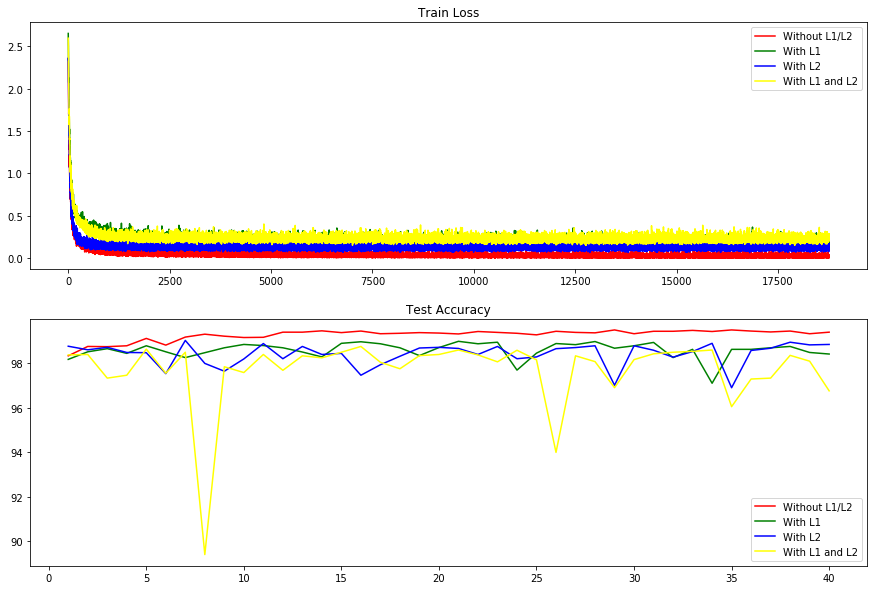

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(df_ts,color='red')
axs[0].plot(df_tsl1,color='green')
axs[0].plot(df_tsl2,color='blue')
axs[0].plot(df_tsl12,color='yellow')
axs[0].legend(['Without L1/L2', 'With L1','With L2','With L1 and L2'], loc='upper right')
axs[0].set_title("Train Loss")
# axs[0].set.xlabel('Epochs')
# axs[0].set.ylabel('Loss')
# axs[0].xticks(range(1,3))


axs[1].plot(df_ts_a.index+1,df_ts_a['acc'],color='red')
axs[1].plot(df_ts_a_l1.index+1,df_ts_a_l1['acc'],color='green')
axs[1].plot(df_ts_a_l2.index+1,df_ts_a_l2['acc'],color='blue')
axs[1].plot(df_ts_a_l12.index+1,df_ts_a_l12['acc'],color='yellow')
axs[1].legend(['Without L1/L2', 'With L1','With L2','With L1 and L2'], loc='lower right')
axs[1].set_title("Test Accuracy")

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
output=[]
with torch.no_grad():
  example_data, example_targets = example_data.to(device), example_targets.to(device)
  output = model(example_data)

In [116]:
example_data.shape

torch.Size([128, 1, 28, 28])

In [120]:
for i in range(128):
  if example_targets[i]== output.data.max(1, keepdim=True)[1][i].item():
  # fig = plt.figure()
  # for i in range(5):
  #   plt.subplot(5,5,i+1)
  #   plt.tight_layout()
    plt.imshow(Tensor.cpu(example_data[i][0].numpy().squeeze()), cmap='gray', interpolation='none')
    plt.title("P: {}".format(
              output.data.max(1, keepdim=True)[1][i].item()))
  #   plt.xticks([])
  #   plt.yticks([])
  # fig

NameError: ignored